In [1]:
import os
import time
import sys
import json
from datetime import datetime
sys.path.append("/global/homes/s/seanjx/gigalens/src")

from gigalens.jax.inference import ModellingSequence
from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.model import PhysicalModel

import tensorflow_probability.substrates.jax as tfp

import jax
from jax import random
from jax import numpy as jnp

import numpy as np
import optax
from matplotlib import pyplot as plt

from astropy.io import fits
from astropy.visualization import simple_norm

import myfunctions
from myfunctions import printToFile

from corner import corner

tfd = tfp.distributions

2024-08-06 17:19:31.664850: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 17:19:31.664879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 17:19:31.774452: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/global/homes/s/seanjx/.conda/envs/myEnvironmentName/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#create output directory
now = "246_"+str(datetime.now())

path = "output/"+now+"/"
os.makedirs(path)
print(now)

246_2024-08-06 17:21:12.343078


2024-08-06 17:21:14.135060: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


-0.016604776


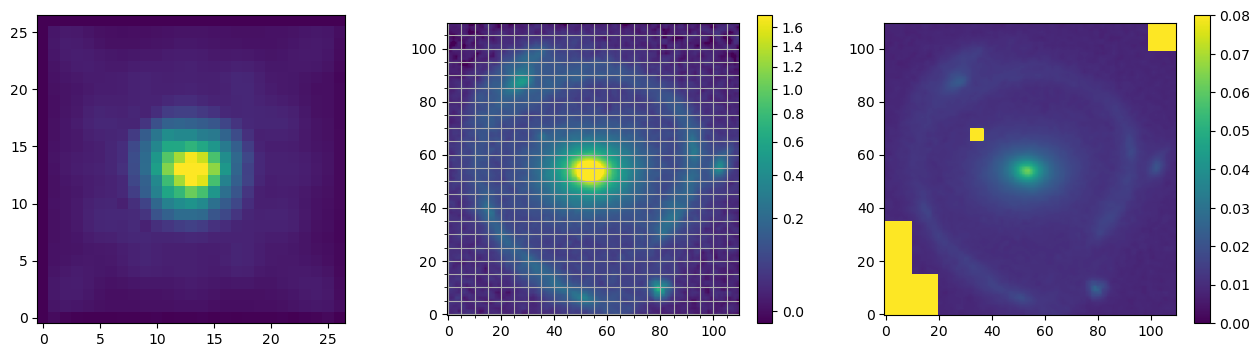

In [3]:
#load observation data, do masking
f=fits.open('psf246.fits') 
psf=jnp.array(f[0].data)

observed_img = np.load("cutout246.npy")

f=fits.open('final_96_drz.fits')
background_rms=0.00788315
exp_time=f[0].header["EXPTIME"]
deltaPix = f[0].header["D002SCAL"]
numPix = np.shape(observed_img)[0]

err_map = np.sqrt(background_rms**2 + observed_img/exp_time)
threshold_lens=1.
error_masked=err_map
#error_masked[45:65,45:65]=np.where(observed_img[45:65,45:65]>threshold_lens, 120000, error_masked[45:65,45:65]) #mask the lens
#error_masked[2:18,72:88]=np.where(observed_img[2:18,72:88]>0.1, 120000, error_masked[2:18,72:88])
error_masked[66:70,33:37]=np.where(observed_img[66:70,33:37]>0, 120000, error_masked[66:70,33:37])
error_masked[0:35,0:10]=np.where(observed_img[0:35,0:10]>0, 120000, error_masked[0:35,0:10])
error_masked[0:15,10:20]=np.where(observed_img[0:15,10:20]>0, 120000, error_masked[0:15,10:20])
error_masked[100:110,100:110]=np.where(observed_img[100:110,100:110]>-0.1, 120000, error_masked[100:110,100:110])

plt.figure(figsize=(16,4))
norm = simple_norm(psf, 'sqrt', percent=99.)
plt.subplot(131)
plt.imshow(psf, norm=norm, origin='lower', cmap='viridis')


norm = simple_norm(observed_img, 'sqrt', percent=99.)
plt.subplot(132)
plt.imshow(observed_img, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
plt.minorticks_on()
plt.grid(which="both",visible=True)

plt.subplot(133)
plt.imshow(err_map, vmin=0,vmax=0.08, origin='lower')
plt.colorbar()

np.save(path+"/err_map.npy",err_map)
print(np.min(observed_img))

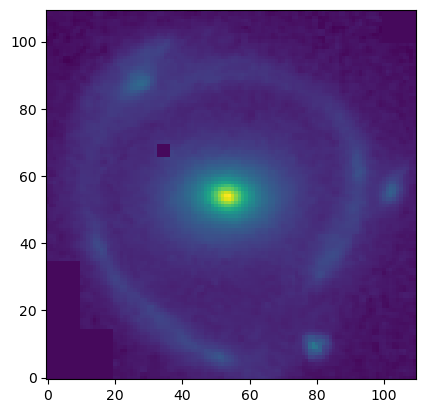

In [4]:
plt.imshow(np.divide(observed_img,err_map), origin='lower', cmap='viridis')

In [5]:
prior, phys_model = myfunctions.readJson("prior.json")[0:2]
os.popen(f'cp prior.json "{path}prior.json"')

sim_config = SimulatorConfig(delta_pix=deltaPix, num_pix=numPix, supersample=1, kernel=psf)
lens_sim = LensSimulator(phys_model, sim_config, bs=1)

prob_model = BackwardProbModel(prior, observed_img, error_masked, background_rms=background_rms, exp_time=exp_time)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

In [6]:
priorObjects = myfunctions.getPriors(phys_model)
numParams = myfunctions.countParameters(phys_model)
print(numParams,priorObjects)

47 (['EPL', 'SHEAR'], ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'], ['SHAPELETS', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'])


In [ ]:
start = time.perf_counter()

n_samples_bs = 500
schedule_fn = optax.polynomial_schedule(init_value=-1e-2, end_value=-1e-4, 
                                      power=0.5, transition_steps=1000)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)

map_estimate, chi = model_seq.MAP(opt, n_samples=n_samples_bs,num_steps=1000,seed=0)
end = time.perf_counter()
MAPtime = end - start
print(MAPtime)

  0%|          | 0/1000 [00:00<?, ?it/s]2024-08-06 17:21:34.551714: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=5,k13=1,k14=3,k18=1,k23=0} for conv (f32[125,142,110,110]{3,2,1,0}, u8[0]{0}) custom-call(f32[125,142,110,110]{3,2,1,0}, f32[142,1,27,27]{3,2,1,0}), window={size=27x27 pad=13_13x13_13}, dim_labels=bf01_oi01->bf01, feature_group_count=142, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-08-06 17:21:35.872408: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.32081114s
Trying algorithm eng36{k2=5,k13=1,k14=3,k18=1,k23=0} for conv (f32[125,142,110,110]{3,2,1,0}, u8[0]{0}) custom-call(f32[125,142,110,110]{3,2,1,0}, f32[142,1,27,27]{3,2,1,0}), window={size=27x27 pad=13_13x13_13},

In [ ]:
plt.style.use("default")
np.save(path+"/map.npy",map_estimate)
plt.plot(np.array(chi))
plt.savefig(path+"/chi-squared.png")

In [ ]:
start = time.perf_counter()
print(datetime.now())

try:
    lps = prob_model.log_prob(LensSimulator(phys_model, sim_config, bs=n_samples_bs), map_estimate)[0]
    best = map_estimate[jnp.nanargmax(lps)][jnp.newaxis,:]
except:
    map_estimate=np.load(path+"/map.npy")
    lps = prob_model.log_prob(LensSimulator(phys_model, sim_config, bs=n_samples_bs), map_estimate)[0]
    best = map_estimate[jnp.nanargmax(lps)][jnp.newaxis,:]

end = time.perf_counter()
logProbTime = end-start
print(logProbTime)

In [ ]:
np.save(path+"/best.npy",best)

In [ ]:
params = prob_model.bij.forward(best.tolist()[0])
simulated = lens_sim.lstsq_simulate(params,jnp.array(observed_img),err_map)[0]

plt.figure(figsize=(12, 4))

plt.subplot(131)
norm = simple_norm(observed_img, 'sqrt', percent=99.)
plt.imshow(observed_img, norm=norm, origin='lower', cmap='viridis')
plt.colorbar(shrink=0.7)

plt.subplot(132)
plt.imshow(simulated, norm=norm, origin='lower', cmap='viridis')
plt.colorbar(shrink=0.7)
plt.axis('off')

plt.subplot(133)
resid = jnp.array(observed_img) - simulated
plt.imshow(resid/err_map, cmap='coolwarm', origin='lower',interpolation='none', vmin=-5.5, vmax=5.5)

MAPchi = np.mean((resid/err_map)**2)
plt.axis('off')
plt.colorbar(shrink=0.7)

print(MAPchi)
plt.savefig(path+"/MAPoutput.png")
print(params)

In [ ]:
start = time.perf_counter()
steps=2000

try:
    schedule_fn = optax.polynomial_schedule(init_value=0, end_value=-1e-4, power=0.5, transition_steps=steps)
    opt = optax.chain(optax.scale_by_adam(),optax.scale_by_schedule(schedule_fn),)
    qz, loss_hist = model_seq.SVI(best, opt, n_vi=500, num_steps=steps)
        
    plt.plot(loss_hist)
    plt.savefig(path+"/SVIloss.png", transparent=True)
    
    mean=qz.mean()
    cov=qz.covariance()
    scale = np.linalg.cholesky(cov)
    
    printToFile("Normal SVI success",path+"output.txt")
except: 
    
    printToFile("Normal SVI failed, skipping...",path+"output.txt")
    schedule_fn = optax.polynomial_schedule(init_value=0, end_value=-1e-15, power=2, transition_steps=500)
    opt = optax.chain(optax.scale_by_adam(),optax.scale_by_schedule(schedule_fn),)
    qz, loss_histFAIL = model_seq.SVI(best, opt, n_vi=500, num_steps=500)
    
    mean=qz.mean()
    cov=qz.covariance()
    scale = np.linalg.cholesky(cov)

end = time.perf_counter()
SVItime = end-start

print(SVItime)

In [ ]:
start = time.perf_counter()
print(datetime.now())
num_samples = 750
samples = model_seq.HMC(qz, num_burnin_steps=250, num_results=num_samples)
end = time.perf_counter()

HMCtime = end-start
#np.save(path+"/HMC.npy",samples)
print(HMCtime)

In [ ]:
rhat= tfp.mcmc.potential_scale_reduction(jnp.transpose(samples.all_states, (1,2,0,3)), independent_chain_ndims=2)
ESS= tfp.mcmc.effective_sample_size(jnp.transpose(samples.all_states, (1,2,0,3))[:,:,:,:], cross_chain_dims=(1,2))
print(rhat)
print(ESS)

In [ ]:
smp = jnp.transpose(samples.all_states, (1,2,0,3)).reshape((-1, numParams))
smp_physical = prob_model.bij.forward(list(smp.T))

stack = []
for ii, priorSet in enumerate(priorObjects):
    for iii, priorObject in enumerate(priorSet):
        if priorObject == "EPL":
            stack.extend([
                            smp_physical[ii][iii]["center_x"],
                            smp_physical[ii][iii]["center_y"],
                            smp_physical[ii][iii]["e1"],
                            smp_physical[ii][iii]["e2"],
                            smp_physical[ii][iii]["gamma"],
                            smp_physical[ii][iii]["theta_E"],
            ])
        elif priorObject == "SHEAR":
            stack.extend([
                            smp_physical[ii][iii]["gamma1"],
                            smp_physical[ii][iii]["gamma2"],
            ])
        elif priorObject == "SERSIC_ELLIPSE":
            stack.extend([
                            smp_physical[ii][iii]["R_sersic"],
                            smp_physical[ii][iii]["center_x"],
                            smp_physical[ii][iii]["center_y"],
                            smp_physical[ii][iii]["e1"],
                            smp_physical[ii][iii]["e2"],
                            smp_physical[ii][iii]["n_sersic"],
            ])
        elif priorObject == "SHAPELETS":
            stack.extend([
                            smp_physical[ii][iii]["beta"],
                            smp_physical[ii][iii]["center_x"],
                            smp_physical[ii][iii]["center_y"],
            ])
        elif priorObject == "SIS":
            stack.extend([
                            smp_physical[ii][iii]["center_x"],
                            smp_physical[ii][iii]["center_y"],
                            smp_physical[ii][iii]["theta_E"],
            ])
            
get_samples = np.column_stack(stack)
physical_samples = get_samples

reversed_physical_samples = np.zeros([num_samples*48,numParams])
reversed_physical_samples[:,0:6]=np.flip(physical_samples[:,0:6])
reversed_physical_samples[:,6:8]=np.flip(physical_samples[:,6:8])
reversed_physical_samples[:,8:numParams] = physical_samples[:,8:numParams]

best_HMC=prob_model.pack_bij.forward(np.median(physical_samples,axis=0).tolist())
with open(path+"/bestHMC.json","w") as file:
    json.dump(best_HMC,file,indent=4)

In [ ]:
plt.style.use('default')

labels=[r'$\theta_E$', 
        r'$\gamma$', 
        r'$\epsilon_1$', 
        r'$\epsilon_2$', 
        r'$x$', r'$y$', 
        r'$\gamma_{1,ext}$', 
        r'$\gamma_{2,ext}$']

corner(reversed_physical_samples[:,0:8], show_titles=True, title_fmt='.3f', labels=labels)
print("peepeepoopoo")
plt.savefig(path+"corner.png", transparent=True)

In [ ]:
corner(reversed_physical_samples, show_titles=True, title_fmt='.3f', );
plt.savefig(path+"bigcorner.png")

In [ ]:
simulated, coeffs = lens_sim.lstsq_simulate(best_HMC,jnp.array(observed_img),err_map)
resid = jnp.array(observed_img) - simulated
chi2 = np.sum((resid/err_map)**2)
dof = len(np.reshape(err_map,-1)[np.reshape(err_map,-1)<1])-numParams
HMCchi = chi2/dof

In [ ]:
printToFile(now+"\n", path+"output.txt")
printToFile(str(jax.devices())+"\n", path+"output.txt")
printToFile(str([numParams,priorObjects]),path+"output.txt")

In [ ]:
printToFile("MAP took "+str(MAPtime)+" seconds \n",path+"output.txt")
printToFile("log_prob took "+str(logProbTime)+" seconds \n",path+"output.txt")
printToFile('MAP chi-squared: '+str(MAPchi)+ "\n",path+"output.txt")

In [ ]:
printToFile("SVI took "+str(SVItime)+" seconds \n",path+"output.txt")
printToFile("HMC took "+str(HMCtime)+" seconds \n",path+"output.txt")
printToFile('HMC chi-squared: '+str(HMCchi)+ "\n",path+"output.txt")
printToFile('Rhat: '+str(rhat),path+"output.txt")
printToFile('ESS: '+str(ESS),path+"output.txt")

In [ ]:
for i in range(0,len(best_HMC[0])):
    printToFile("lens: "+ str([[ii,float(best_HMC[0][i][ii])] for ii in best_HMC[0][i]])+ "\n",path+"output.txt")

for i in range(0,len(best_HMC[1])):
    printToFile("lens light: "+ str([[ii,float(best_HMC[1][i][ii])] for ii in best_HMC[1][i]])+ "\n",path+"output.txt")

for i in range(0,len(best_HMC[2])):
    printToFile("source light: "+ str([[ii,float(best_HMC[2][i][ii])] for ii in best_HMC[2][i]])+ "\n",path+"output.txt")